In [1]:
import os, sys, pathlib
from pprint import pprint 
from importlib import reload
import logging
from typing import Callable
logging.basicConfig(level=logging.ERROR)
import warnings
warnings.simplefilter("ignore")



import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import scipy.linalg as linalg
from sklearn.cross_decomposition import CCA

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator


from tools import utilityTools as utility
from tools import dataTools as dt
import pyaldata as pyal

%matplotlib inline
reload(dt)

root = pathlib.Path("/data")

In [ ]:
def get_target_id(trial):
    return int(np.round((trial.target_direction + np.pi) / (0.25*np.pi))) - 1

animalList = ['Chewie', 'Mihili']

animalFiles={}
for animal in animalList:
    animalFiles[animal] = utility.find_file(root / animal,'mat')

# just keeping the CS sessions
goodFiles = [file for animal in animalFiles for file in animalFiles[animal] if 'CS' in file]

# keeping 1 session per animal
fileList = ['/data/Chewie/Chewie_CO_CS_2016-10-14.mat', '/data/Mihili/Mihili_CO_VR_2014-03-03.mat']
# fileList = goodFiles


df_data=[]
for fname in fileList:
    df = pyal.mat2dataframe(fname, shift_idx_fields=True)
    df_data.append(df)
    dt.summary(df)
    
    
    
def prep_exec_all_targets (df, n_components=10):
    "preprocessing for execution eopch"
    df["target_id"] = df.apply(get_target_id, axis=1)  # add a field `target_id` with int values

    df_= pyal.select_trials(df, df.result== 'R')
    df_= pyal.select_trials(df_, df_.epoch=='BL')
    
    
    df_ = pyal.combine_time_bins(df_, 3)
    
    
    if "M1_spikes" in df_.columns:
        df_ = pyal.remove_low_firing_neurons(df_, "M1_spikes", 1)
        df_ = pyal.sqrt_transform_signal(df_, "M1_spikes")
    if "PMd_spikes" in df_.columns:
        df_ = pyal.remove_low_firing_neurons(df_, "PMd_spikes", 1)
        df_ = pyal.sqrt_transform_signal(df_, "PMd_spikes")
        
    
    df_= pyal.add_firing_rates(df_, 'smooth')
    
    
    df_ = pyal.restrict_to_interval(df_, start_point_name='idx_movement_on', rel_start=-1, rel_end=15)
    
    if "M1_spikes" in df_.columns:
        M1_rates = np.concatenate(df_.M1_rates.values, axis=0)
        pca_model = PCA(n_components=n_components, svd_solver='full');
        pca_model.fit(M1_rates);
        df_ = pyal.apply_dim_reduce_model(df_, pca_model, 'M1_rates', 'M1_pca');

    if "PMd_spikes" in df_.columns:
        PMd_rates = np.concatenate(df_.PMd_rates.values, axis=0)
        pca_model = PCA(n_components=n_components, svd_solver='full');
        pca_model.fit(PMd_rates);
        df_ = pyal.apply_dim_reduce_model(df_, pca_model, 'PMd_rates', 'PMd_pca');

    
    return df_

df_data_exec = [prep_exec_all_targets(df) for  df in df_data]



def prep_prep_all_targets (df, n_components=10):
    "preprocessing for Preparation epoch"
    df["target_id"] = df.apply(get_target_id, axis=1)  # add a field `target_id` with int values

    df_= pyal.select_trials(df, df.result== 'R')
    df_= pyal.select_trials(df_, df_.epoch=='BL')
    
    
    df_ = pyal.combine_time_bins(df_, 3)
    
    
    if "M1_spikes" in df_.columns:
        df_ = pyal.remove_low_firing_neurons(df_, "M1_spikes", 1)
        df_ = pyal.sqrt_transform_signal(df_, "M1_spikes")
    if "PMd_spikes" in df_.columns:
        df_ = pyal.remove_low_firing_neurons(df_, "PMd_spikes", 1)
        df_ = pyal.sqrt_transform_signal(df_, "PMd_spikes")
        
    
    df_= pyal.add_firing_rates(df_, 'smooth')

    
    df_ = pyal.restrict_to_interval(df_, start_point_name='idx_movement_on', rel_start=-15, rel_end=1)
    
    if "M1_spikes" in df_.columns:
        M1_rates = np.concatenate(df_.M1_rates.values, axis=0)
        pca_model = PCA(n_components=n_components, svd_solver='full');
        pca_model.fit(M1_rates);
        df_ = pyal.apply_dim_reduce_model(df_, pca_model, 'M1_rates', 'M1_pca');

    if "PMd_spikes" in df_.columns:
        PMd_rates = np.concatenate(df_.PMd_rates.values, axis=0)
        pca_model = PCA(n_components=n_components, svd_solver='full');
        pca_model.fit(PMd_rates);
        df_ = pyal.apply_dim_reduce_model(df_, pca_model, 'PMd_rates', 'PMd_pca');

    
    return df_

df_data_prep = [prep_prep_all_targets(df) for  df in df_data]

In [4]:
dfs_prep = [pyal.select_trials(df_,df_.target_id==1) for df_ in df_data_prep]
dfs_exec = [pyal.select_trials(df_,df_.target_id==1) for df_ in df_data_exec]

In [5]:
df1 = dfs_prep[0];
field1='PMd_pca';
df2 = dfs_prep[1];
field2 = 'PMd_pca';

d0 = np.concatenate(df1[field1].values, axis=0)
d1 = np.concatenate(df2[field2].values, axis=0)

# same number of timepoints in both matrices
n_samples = min ([d0.shape[0], d1.shape[0]])
d0 = d0[:n_samples,:]
d1 = d1[:n_samples,:]


(0.0, 1.0)

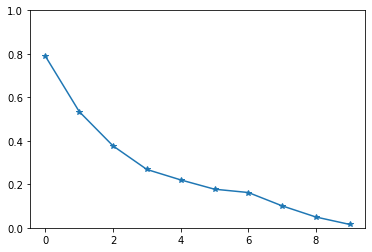

In [11]:
plt.plot(dt.canoncorr(d0, d1), '*-')
plt.ylim([0,1])

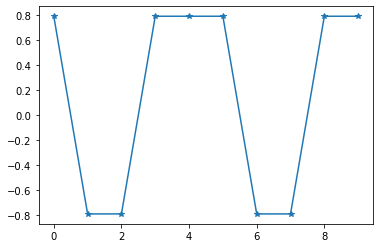

In [44]:
cca = CCA(n_components=10)
X_c, Y_c = cca.fit_transform(d0,d1)
CC2 = np.array([np.corrcoef(X_c[:,j],Y_c[:,j])[0,1] for j in range(10)])
plt.plot(CC2, '*-')


In [40]:
import pickle
data = [d0, d1]
with open('/home/msafaie/Downloads/for_mostafa/data.p','wb') as f:
    pickle.dump(data, f)

In [2]:
import pickle
with open('/home/msafaie/Downloads/for_mostafa/data.p','rb') as f:
    a = pickle.load(f)

d0, d1 = a[0], a[1]

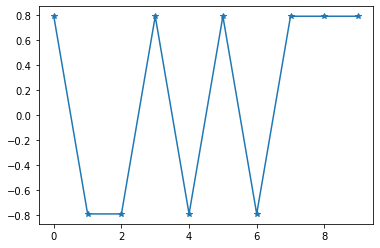

In [3]:
from sklearn.cross_decomposition import CCA
import matplotlib.pyplot as plt
import numpy as np

cca = CCA(n_components=10,max_iter=5000)
X_c, Y_c = cca.fit_transform(d0,d1)
CC2 = np.array([np.corrcoef(X_c[:,j],Y_c[:,j])[0,1] for j in range(10)])
plt.plot(CC2, '*-')


In [4]:
import pickle
data = [X_c, Y_c]
with open('/home/msafaie/Downloads/for_mostafa/data2.p','wb') as f:
    pickle.dump(data, f)

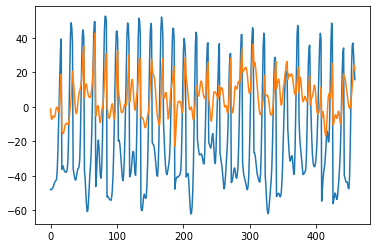

In [24]:
plt.plot(d0[:,:2])